In [1]:
import iris
import iris.cube
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import iris.plot as iplt

In [2]:
path = "/short/tp28/eh6215/noAer/"
ct = iris.Constraint(time=lambda t: t.point.month not in [8,9])
cx = iris.Constraint(longitude=lambda x:85<=x<=210)
cy = iris.Constraint(latitude=lambda y: -55<=y<=15)

In [4]:
noAer = iris.load(path+"cs_noAer*", ct)
iris.util.equalise_attributes(noAer)
noAer


radAer = iris.load(path+"cs_radAer*", ct)
iris.util.equalise_attributes(noAer)
radAer


[<iris 'Cube' of cs_dsfc_sw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_sw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of cs_dsfc_lw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_lw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>]

In [13]:
r6 = iris.load(path+"cs_r6*",ct)
iris.util.equalise_attributes(r6)
r6 = r6.merge()
r6

[<iris 'Cube' of cs_dsfc_lw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_sw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of cs_dsfc_sw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_lw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>]

In [5]:
EA = iris.load(path+"cs_EA_*", ct)
iris.util.equalise_attributes(EA)
EA2 = []
for cube in EA:
    if cube.ndim==2:
        EA2.append(cube)
    elif cube.ndim==3:
        for i in range(cube.shape[0]):
            EA2.append(cube[i])
            
EA=iris.cube.CubeList(EA2).merge()
EA

[<iris 'Cube' of cs_dsfc_sw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_sw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of cs_dsfc_lw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_lw_flx / (W m-2) (time: 10; latitude: 453; longitude: 798)>]

In [8]:
era5 = iris.load(path+"cs_era5*",ct)
iris.util.equalise_attributes(era5)
era5 = era5.merge()
era5 = iris.cube.CubeList([cube.regrid(EA[0],iris.analysis.Linear()) for cube in era5])
era5

[<iris 'Cube' of cs_dsfc_sw_flx / (W m**-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_sw_flx / (W m**-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of cs_dsfc_lw_flx / (W m**-2) (time: 10; latitude: 453; longitude: 798)>,
<iris 'Cube' of av_cs_up_lw_flx / (W m**-2) (time: 10; latitude: 453; longitude: 798)>]

In [10]:
toa = iris.load(path+"toa_era5*","Mean top downward short-wave radiation flux").extract(ct)
iris.util.equalise_attributes(toa)
toa = toa.merge_cube().regrid(EA[0],iris.analysis.Linear())
toa
era5.extract("av_cs_up_sw_flx")[0].data = era5.extract("av_cs_up_sw_flx")[0].data - toa.data

In [11]:
era5.extract("av_cs_up_sw_flx")[0].data = -1*era5.extract("av_cs_up_sw_flx")[0].data 
era5.extract("av_cs_up_lw_flx")[0].data = -1*era5.extract("av_cs_up_lw_flx")[0].data 

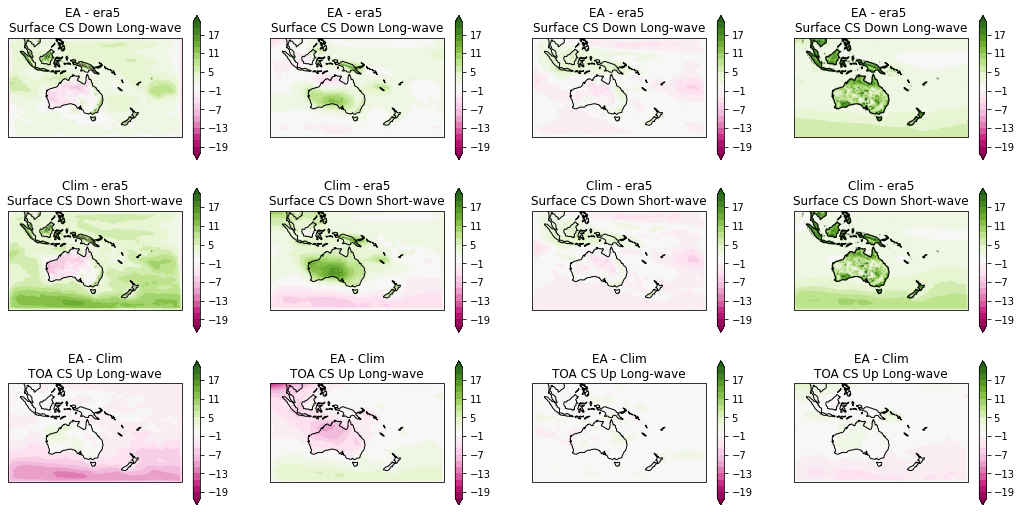

In [28]:
# TOA
names = ["cs_dsfc_lw_flx","cs_dsfc_sw_flx","av_cs_up_lw_flx","av_cs_up_sw_flx"]
names2 = ["Surface CS Down Long-wave","Surface CS Down Short-wave","TOA CS Up Long-wave","TOA Clear-sky Up Short-wave",]
plt.figure(figsize=(18,9))
for i,(data1,data2) in enumerate([(EA,era5),(noAer,era5),(EA,noAer)]):
    for j,name in enumerate(names):
        name2=names2[i]
        cube = (data1.extract_cube(name).data - data2.extract_cube(name).data).mean(axis=0)
        cube = data1[0][0].copy(data=cube)
        #cube = data1.extract_cube(name).collapsed('time',iris.analysis.MEAN)
        ax=plt.subplot(3,4,4*i+j+1,projection=ccrs.PlateCarree(180))
        iplt.contourf(cube,np.arange(-21,22,2),cmap='PiYG',extend='both')
        #iplt.contourf(cube,[np.arange(230,311,10),np.arange(0,120,10),np.arange(225,426,20),np.arange(180,340,20)][j])#,np.arange(-21,22,2),cmap='PiYG',extend='both')
        plt.title(['EA - era5 \n', 'Clim - era5\n','EA - Clim\n'][i]+name2)
        plt.colorbar()
        ax.coastlines()
    

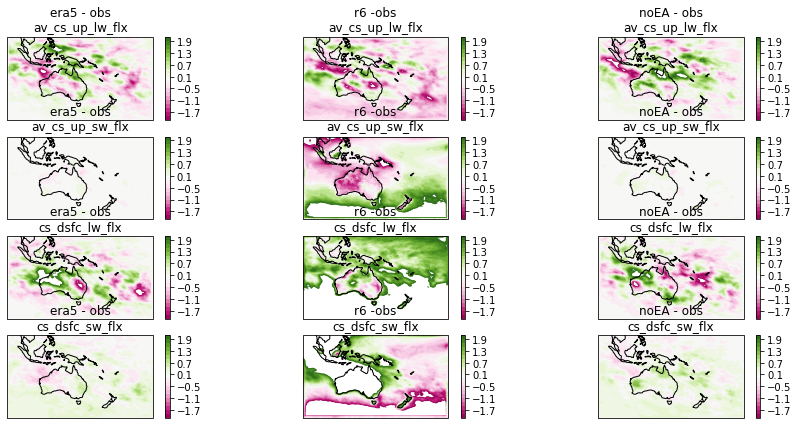

In [22]:
names = ["av_cs_up_lw_flx","av_cs_up_sw_flx","cs_dsfc_lw_flx","cs_dsfc_sw_flx"]

plt.figure(figsize=(15,7))
for i,(data1,data2) in enumerate([(EA,r6),(noAer,r6),(radAer,r6)]):
    for j,name in enumerate(names):
        cube = (data1.extract_cube(name).data - data2.extract_cube(name).data).mean(axis=0)
        cube = data1[0][0].copy(data=cube)
        ax=plt.subplot(4,3,i+3*j+1,projection=ccrs.PlateCarree(180))
        iplt.contourf(cube,np.arange(-2.1,2.2,0.2),cmap='PiYG')
        plt.title(['era5 - obs\n','r6 -obs\n', 'noEA - obs\n','radEA-obs\n',"noEA - r6\n",'radEA - r6\n'][i]+name)
        plt.colorbar()
        ax.coastlines()
    

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


ValueError: num must be 1 <= num <= 16, not 17

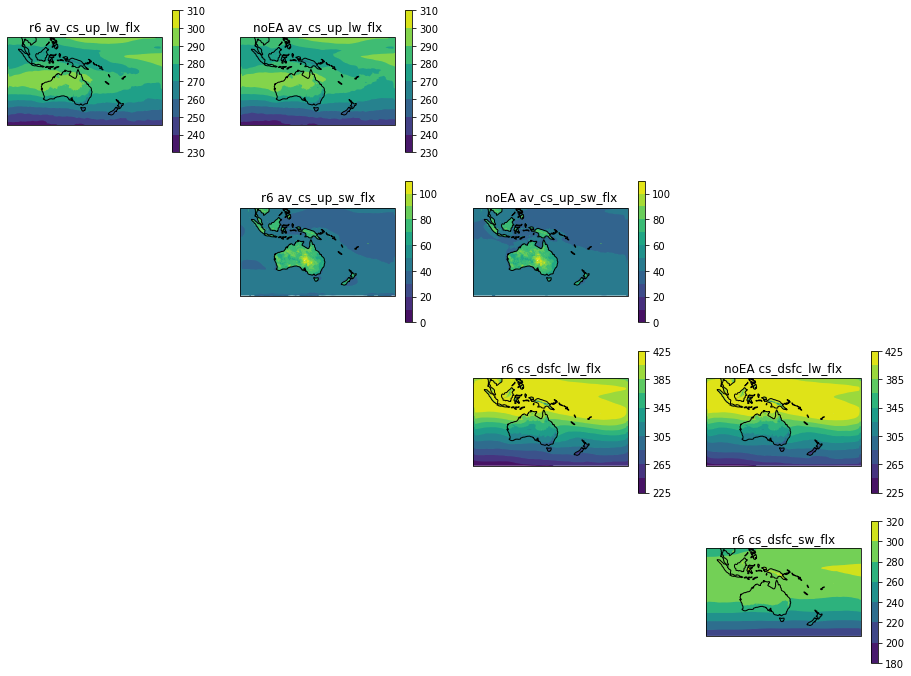

In [21]:
# TOA
names = ["av_cs_up_lw_flx","av_cs_up_sw_flx","cs_dsfc_lw_flx","cs_dsfc_sw_flx"]

plt.figure(figsize=(16,12))
for i,(data1,data2) in enumerate([(r6,era5),(noAer,era5),(radAer,era5),(era5,r6)]):
    for j,name in enumerate(names):
        cube = data1.extract_cube(name).collapsed('time',iris.analysis.MEAN)
        ax=plt.subplot(4,4,i+5*j+1,projection=ccrs.PlateCarree(180))
        iplt.contourf(cube,[np.arange(230,311,10),np.arange(0,120,10),np.arange(225,426,20),np.arange(180,340,20)][j])#,np.arange(-21,22,2),cmap='PiYG',extend='both')
        plt.title(['r6 ', 'noEA ','radEA ','era5 '][i]+name)
        plt.colorbar()
        ax.coastlines()